# Introduction

This is a project about recreating a guitar sound. The aim is to analyze a recording of a guitar, extract its overtone envelopes, and rebuild the sound using those envelopes. If all that sounds complicated, the basic idea is to deconstruct the recording into special sine waves, then reconstruct it using those special sine waves. At the very end of this notebook, you can compare the original audio with the synthesized recreation by listening to both.

The signal processing in this notebook is mostly done using numpy and scipy, as these contain some very handy functions. IPython is used for listening to audio files, matplotlib is used for plotting.

The file "Guitar 100Hz.wav" should be inside the same folder as this ipynb file, otherwise the import won't work. If you got this notebook from my github repo (https://github.com/LassiGithub/Guitar-sound-recreation), the file should already be there.

Here are the steps taken in this notebook:
1. Import the audio file of the guitar recording
2. Apply fast fourier transform (FFT) in chunks to get amplitude envelopes of the guitar's overtones
3. Smoothen these envelopes with a low-pass filter
4. Recreate the sound by modulating sinusoids with these envelopes and adding them together

</br></br>

# Detailed information

## Frequency of the guitar note

The recording of the guitar is a single note at 100Hz frequency. The original note that I recorded wasn't 100Hz, but I edited it to be exactly that. This makes the overtone analysis easier, because the overtones are located at multiples of this fundamental frequency (100Hz, 200Hz, 300Hz...) and the FFT will nicely analyze these exact frequencies if you apply it to an array of size 441. I wanted the FFT to also analyze the frequencies in between the overtones, so I applied it to arrays of size 882. In this case the FFT will analyze frequencies that are multiples of 50Hz, and that includes multiples of 100Hz. That is where the chunk size of 882 comes from.

## Amplitude envelopes

The amplitude envelopes show how the amplitude of an overtone changes over time. These are created by taking chunks of the audio at different points in time, then applying FFT to each chunk to see how loud each overtone was at that specific time. I noticed these envelopes weren't very smooth, so I decided to smoothen them with a low-pass filter. 

I'm not entirely sure where this "roughness" comes from. It might be because the overtones aren't always exactly at the frequencies I analyze. Perhaps the envelopes just aren't smooth in reality. In any case, the envelopes that I got aren't exacly correct, because the higher recreated overtones sound noisy and slightly wrong. 

The roughness acts as very fast amplitude modulation, which results in other frequencies appearing when modulating just a single pure sinusoid. The smoothening of the envelopes solves this, but it didn't solve all the problems I had with the recreated overtones. This is why I only used 20 lowest overtones in the recreation.

## Quality of the recreation

The recreation isn't perfect, and there might be a better way to approach this than vanilla FFT. I still think it's surprisingly good. It doesn't sound exactly like the original, but it does sound very similar. After all, it's not just the overtones that contain the information of a sound. I only recreated some of the overtones, and it still sounds decent. I'm quite happy with the result!

</br></br></br></br></br>

# Importing the audio file

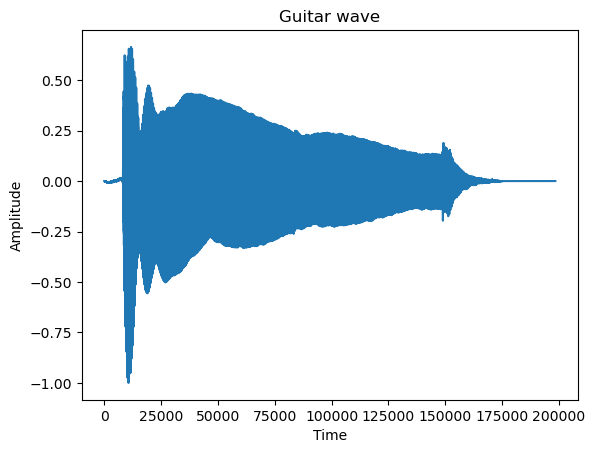

In [1]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

# Import the wav file as a numpy array
guitar_wav = wavfile.read("Guitar 100Hz.wav")
guitar_np = np.array(guitar_wav[1],dtype=float)

# The audio file has two channels (left and right)
# We only need one, and in this file they're identical anyway
# So we only take the left channel
guitar_np = guitar_np[:,0]

# Normalize the values to range from -1 to 1
# This is a 16-bit wav file, so the amplitude values range from -(2^15) to 2^15
# (These are the minimum and maximum values of a 16-bit integer)
# Thus we divide by 2^15 to normalize the values
guitar_np_normalised = guitar_np / 2**15 

# Plot the wave
plt.title("Guitar wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(guitar_np_normalised)
plt.show()

# Display the audio file for listening
IPython.display.Audio("Guitar 100Hz.wav")

</br></br></br></br></br>

# Applying FFT in chunks

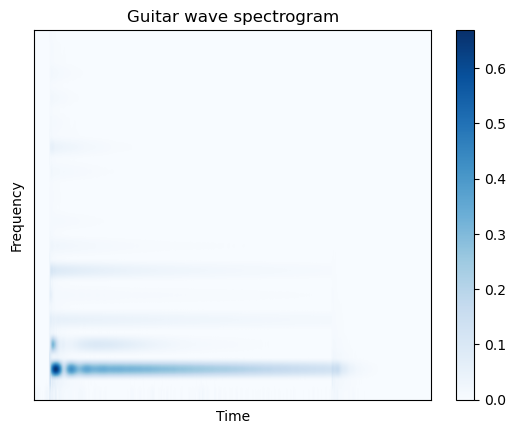

In [2]:
# Here we apply fast fourier transform (FFT) in chunks to the audio
# In other words, we divide the audio into many overlapping pieces, then apply FFT to each of them
# 
# The fourier transform tells infromation about how loud different frequencies are in a signal
# Doing this in chunks tells us how those loudnesses (amplitudes) change over time
# We can visualize this as a spectrogram, where the color indicates amplitude, y-axis frequency, x-axis time
# 
# In the resulting spectrogram (below), you can recognize some light horizontal lines
# These are the loudest frequencies of the sound, the overtones of the sound
# They are what we aim to analyze and recreate the original sound with

from numpy.fft import fft, ifft

# Create chunks of size 882 from the audio
# This makes the base frequency of each chunk be 50Hz
# The chunks overlap, each is offset by only one sample compared to the previous one
fft_chunk_length = 882
amount_of_chunks = guitar_np_normalised.size - fft_chunk_length
audio_chunks = []

for i in range(amount_of_chunks):
    audio_chunks.append(guitar_np_normalised[i:(i+fft_chunk_length)]) 

# Perform FFT to each chunk
fft_coefs = fft(audio_chunks)

# Convert the fourier coefficients into amplitude values of the frequencies
# We will also divide them by 441 to get them to a reasonable range for our uses
fft_amplitudes = np.abs(fft_coefs) / 441

# Plot some of the amplitudes as a heatmap
plot_data = fft_amplitudes[:,0:30]
plot_data = np.transpose(plot_data)[::-1]
plt.imshow(plot_data, aspect='auto', cmap='Blues')
plt.xticks([])
plt.yticks([])
plt.title("Guitar wave spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

</br></br></br></br></br>

# Plotting envelopes

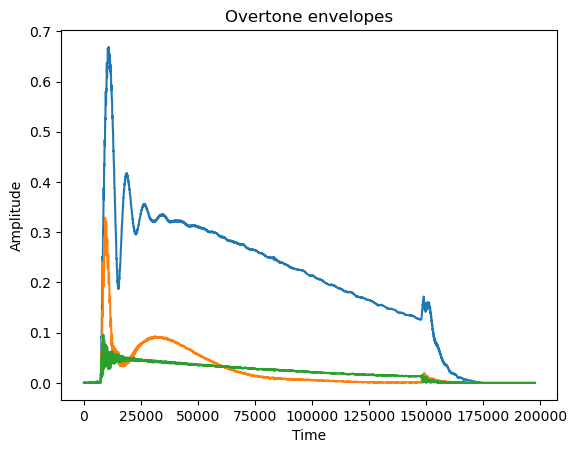

In [3]:
# Here we plot the envelopes of the first three overtones (including the fundamental frequency as an overtone)
# The envelopes shows how a specific overtone's amplitude changes in time
# These envelopes are just slices of the spectrogram 
# The first three overtones correspond to the lowest three lines in the spectrogram above

# Get the envelopes
env_0 = fft_amplitudes[:,2] #100Hz
env_1 = fft_amplitudes[:,4] #200Hz
env_2 = fft_amplitudes[:,6] #300Hz

# Plot
plt.plot(env_0)  # Blue
plt.plot(env_1) # Yellow
plt.plot(env_2) # Green
plt.title("Overtone envelopes")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

</br></br></br></br></br>

# Filtering envelopes

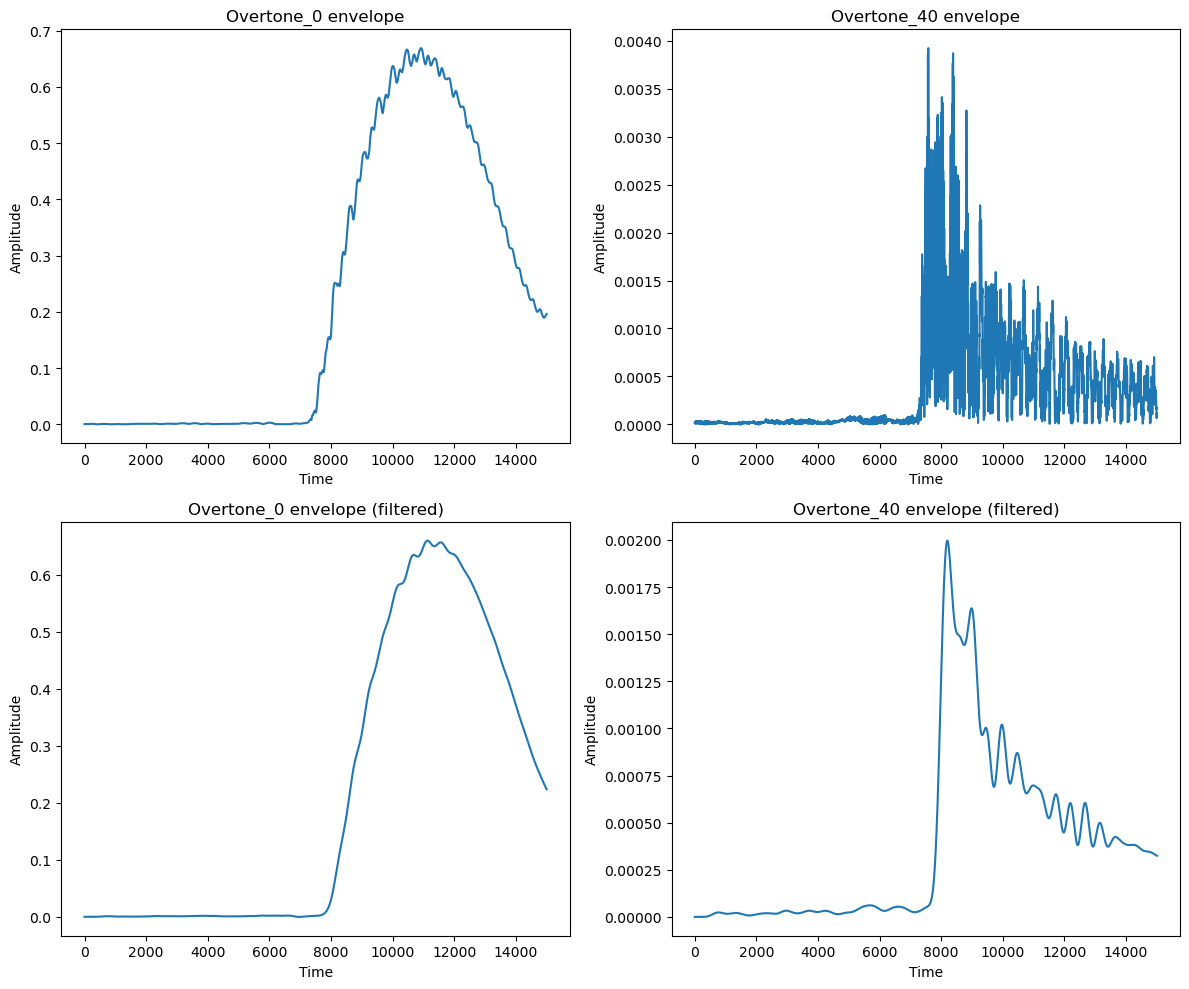

In [5]:
# When you zoom in to any of these envelopes, you can notice that they aren't very smooth
# You can see this in the plots below
# I'm not entirely sure what the reason for this is, but I decided to smoothen them with a filter
# 
# This cell is only to visualize what the filtering does to the envelopes (to decide the strength of the filter)
# We create the filter here, but don't apply it to all the envelopes yet
# That will be done later, when we synthesize a note

from scipy import signal

# Create a low-pass filter
# The settings of this filter were determined visually, by trying out values and looking at the plots below
lp_filter = signal.butter(10, 0.004, 'low', output='sos')

# Apply the filter to two overtones
env_0 = fft_amplitudes[:,2]
env_40 = fft_amplitudes[:,82]
filtered_env_0 = signal.sosfilt(lp_filter, env_0)
filtered_env_40 = signal.sosfilt(lp_filter, env_40)

# Plot the filtered and unfiltered amplitude curves
# We only plot the beginning of the envelopes to see a zoomed in view
fig, ax = plt.subplots(2,2, figsize=(12, 10))

ax[0,0].plot(env_0[0:15000])
ax[0,0].set_title("Overtone_0 envelope")

ax[0,1].plot(env_40[0:15000])
ax[0,1].set_title("Overtone_40 envelope")

ax[1,0].plot(filtered_env_0[0:15000])
ax[1,0].set_title("Overtone_0 envelope (filtered)")

ax[1,1].plot(filtered_env_40[0:15000])
ax[1,1].set_title("Overtone_40 envelope (filtered)")

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel("Time")
        ax[i,j].set_ylabel("Amplitude")

fig.tight_layout()
plt.show()

</br></br></br></br></br>

# Synthesizing a note

In [7]:
# This is where we synthesize a note using the envelopes
# The resulting audio file should appear in the same folder as this notebook is in, but you can also listen to it below
#
# You can try changing some values to see how they change the resulting note
#
# Fun values to change include: 
#     - base_freq:      Changes the pitch
#     - overtone_amt:   Changes how many overtones to include (More -> Brighter sound)
#     - sr:             Changes the speed (not the purpose of the variable, but does this as a byproduct)
#     - lp_filter:      https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html


# Samplerate
sr = 44100

# Basic attributes of our note
amplitude = 1.0 # Don't change this value, you might accidently make something very loud
base_freq = 100
overtone_amt = 20

# The same low-pass filter as previously
# I added it here so that it's easy to adjust if you want to experiment with different filters
lp_filter = signal.butter(10, 0.004, 'low', output='sos')

# Get audio arrays for 20 first overtones
overtone_audio_arrays = []
for i in range (0,overtone_amt):
    # Get the envelope of the overtone
    overtone_envelope = fft_amplitudes[:,(i+1)*2] 
    
    # Filter (smoothen) the envelope
    overtone_envelope_filtered = signal.sosfilt(lp_filter, overtone_envelope)
    
    # Create a sinusoid with random phase, frequency of the overtone, (array) length of the signal
    # It's done in a complicated looking way, but that's all it is
    # The array 't' is essentially an array that counts seconds according to the sample rate
    # So the 44100th index is 1, (44100*2)th index is 2, and so on...
    # This makes it easy to transform that array into a sinusoid with the frequency we want
    freq = (i+1)*base_freq
    r_phase = np.random.uniform(2*np.pi)
    signal_size = overtone_envelope_filtered.size
    t = np.linspace(0., signal_size/sr, signal_size, endpoint = False)
    sinusoid = amplitude * np.sin(2. * np.pi * freq * t + r_phase)
    
    # Modulate the aplitude of the sinusoid by the envelope
    # This simply means multiplying the two signals together
    modulated_sinusoid = np.multiply(overtone_envelope_filtered, sinusoid)
    
    # Append to overtone list
    overtone_audio_arrays.append(modulated_sinusoid)
    

# Sum all the overtone audio arrays together
final_audio_array = np.sum(overtone_audio_arrays, axis=0)    
      
# Write the resulting audio array as a .wav file
filename = 'Synthesized guitar.wav'
wavfile.write(filename, sr, final_audio_array.astype(np.float32))

</br></br></br></br></br>

# Listening comparison

In [8]:
# Original audio
IPython.display.Audio("Guitar 100Hz.wav")

In [9]:
# Synthesized recreation
IPython.display.Audio("Synthesized guitar.wav")